In [4]:
import pandas as pd

## Pre process


In [5]:
sleep_data = pd.read_csv('data/minuteSleep_merged.csv')
sleep_df = pd.DataFrame(sleep_data)

Lets transform the minute_sleep data frame into detailed_sleep_data. Sleep_df contains the data for every minute of a sleep session. The value row indicates the sleep state which has meaning stated in Fitabase data dictionary as:
1: asleep
2: restless
3: awake

In [6]:
# Convert date column to datetime type
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

# Aggregate minute_sleep data to get detailed_sleep_data
detailed_sleep_data = sleep_df.groupby(['Id', 'logId']).agg(
    start_time=('date', 'min'),
    end_time=('date', 'max'),
    total_minutes=('value', 'count'),
    asleep_minutes=('value', lambda x: (x == 1).sum()),
    restless_minutes=('value', lambda x: (x == 2).sum()),
    awake_minutes=('value', lambda x: (x == 3).sum())
).reset_index()

In [7]:
detailed_sleep_data.head()

,Id,logId,start_time,end_time,total_minutes,asleep_minutes,restless_minutes,awake_minutes
0,1503960366,11114919637,2016-03-13 02:39:30,2016-03-13 09:44:30,426,411,15,0
1,1503960366,11126343681,2016-03-14 01:32:00,2016-03-14 07:57:00,386,354,27,5
2,1503960366,11134971215,2016-03-15 02:36:00,2016-03-15 08:10:00,335,312,16,7
3,1503960366,11142197163,2016-03-16 03:12:00,2016-03-16 08:14:00,303,272,26,5
4,1503960366,11142197164,2016-03-16 19:43:00,2016-03-16 20:45:00,63,61,2,0


Now we will handle the heartrate data, lets take out all the heartrate data related to the sleep of the user.

In [8]:
heartrate_data = pd.read_csv('data/heartrate_seconds_merged.csv')
heartrate_df = pd.DataFrame(heartrate_data)

In [9]:
# Convert Time column to datetime type
heartrate_df['Time'] = pd.to_datetime(heartrate_df['Time'])

In [10]:
# Function to filer out the heartrate based on users sleep session
def filter_heartrate_from_sleep(sleep_data_row, heart_rate_data):
    filter_data = heart_rate_data[(heart_rate_data['Time'] >= sleep_data_row['start_time']) & 
                                 (heart_rate_data['Time'] <= sleep_data_row['end_time'])]
    return filter_data

In [11]:
# Apply the function to each row of detailed_sleep_data
heart_rate_sleep_data = detailed_sleep_data.apply(lambda row: filter_heartrate_from_sleep(row, heartrate_df), axis=1)

# Concatenate the filtered heart rate data into a single DataFrame
heart_rate_sleep_data = pd.concat(heart_rate_sleep_data.tolist())

heart_rate_sleep_data['Time']= heart_rate_sleep_data['Time'].dt.date

print(heart_rate_sleep_data)

                 Id        Time  Value
57626    2347167796  2016-03-29     67
57627    2347167796  2016-03-29     68
57628    2347167796  2016-03-29     68
57629    2347167796  2016-03-29     69
57630    2347167796  2016-03-29     68
...             ...         ...    ...
1137241  8877689391  2016-04-09     79
1137242  8877689391  2016-04-09     80
1137243  8877689391  2016-04-09     79
1137244  8877689391  2016-04-09     78
1137245  8877689391  2016-04-09     79

[3848143 rows x 3 columns]


Lets find the lowers observed heartrate during every night for every user and call this resting heart rate

In [12]:
rhr_df = heart_rate_sleep_data.groupby(['Id','Time']).agg(
    resting_heart_rate = ('Value', 'min')
).reset_index()

print(rhr_df)

             Id        Time  resting_heart_rate
0    2022484408  2016-04-01                  53
1    2022484408  2016-04-02                  55
2    2022484408  2016-04-03                  50
3    2022484408  2016-04-04                  54
4    2022484408  2016-04-05                  53
..          ...         ...                 ...
138  8877689391  2016-04-08                  54
139  8877689391  2016-04-09                  49
140  8877689391  2016-04-10                  53
141  8877689391  2016-04-11                  47
142  8877689391  2016-04-12                  47

[143 rows x 3 columns]


Now lets merge the sleep and rhr to one dataframe for simplicity

In [13]:
detailed_sleep_data['start_time'] = pd.to_datetime(detailed_sleep_data['start_time']).dt.date
detailed_sleep_data['end_time'] = pd.to_datetime(detailed_sleep_data['end_time']).dt.date

# Merge detailed_sleep_data and recovery_df on 'Id' and 'start_time'/'end_time'
recovery_merged = pd.merge(detailed_sleep_data, rhr_df, left_on=['Id', 'start_time'], right_on=['Id', 'Time'], how='inner')
recovery_merged.drop('Time', axis=1, inplace=True)

# Display the resulting DataFrame
print(recovery_merged)

            Id        logId  start_time    end_time  total_minutes  \
0   2026352035  11292296207  2016-04-02  2016-04-03            580   
1   2347167796  11258976452  2016-03-29  2016-03-30            529   
2   2347167796  11267974466  2016-03-30  2016-03-31            534   
3   2347167796  11277129330  2016-03-31  2016-04-01            529   
4   2347167796  11285072012  2016-04-02  2016-04-02            459   
..         ...          ...         ...         ...            ...   
92  8792009665  11339506278  2016-04-08  2016-04-08            178   
93  8792009665  11341973497  2016-04-08  2016-04-08            269   
94  8792009665  11346641639  2016-04-09  2016-04-09            281   
95  8792009665  11349628943  2016-04-09  2016-04-09            277   
96  8792009665  11357751881  2016-04-09  2016-04-09             80   

    asleep_minutes  restless_minutes  awake_minutes  resting_heart_rate  
0              528                43              9                  57  
1          

Now lets normalize asleep_minutes and resting heart rate!

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
recovery_merged[['asleep_minutes_norm', 'resting_heart_rate_norm']] = scaler.fit_transform(recovery_merged[['asleep_minutes', 'resting_heart_rate']])


Lets build a function that calculate a recover of 0 - 100% based on the rhr and asleep min norm

In [15]:
def calculate_recovery_score(asleep_min_norm, rhr_norm):
    rhr_weight = 0.6
    asleep_weight = 0.4

    recovery_score = (rhr_weight * rhr_norm) + (asleep_weight * (1 - asleep_min_norm))

    recovery_score = recovery_score * 100

    return recovery_score

LETS CALCULATE!!

In [16]:
recovery_merged['Recovery_score'] = calculate_recovery_score(recovery_merged['asleep_minutes_norm'], recovery_merged['resting_heart_rate_norm'])

print(recovery_merged)

            Id        logId  start_time    end_time  total_minutes  \
0   2026352035  11292296207  2016-04-02  2016-04-03            580   
1   2347167796  11258976452  2016-03-29  2016-03-30            529   
2   2347167796  11267974466  2016-03-30  2016-03-31            534   
3   2347167796  11277129330  2016-03-31  2016-04-01            529   
4   2347167796  11285072012  2016-04-02  2016-04-02            459   
..         ...          ...         ...         ...            ...   
92  8792009665  11339506278  2016-04-08  2016-04-08            178   
93  8792009665  11341973497  2016-04-08  2016-04-08            269   
94  8792009665  11346641639  2016-04-09  2016-04-09            281   
95  8792009665  11349628943  2016-04-09  2016-04-09            277   
96  8792009665  11357751881  2016-04-09  2016-04-09             80   

    asleep_minutes  restless_minutes  awake_minutes  resting_heart_rate  \
0              528                43              9                  57   
1        

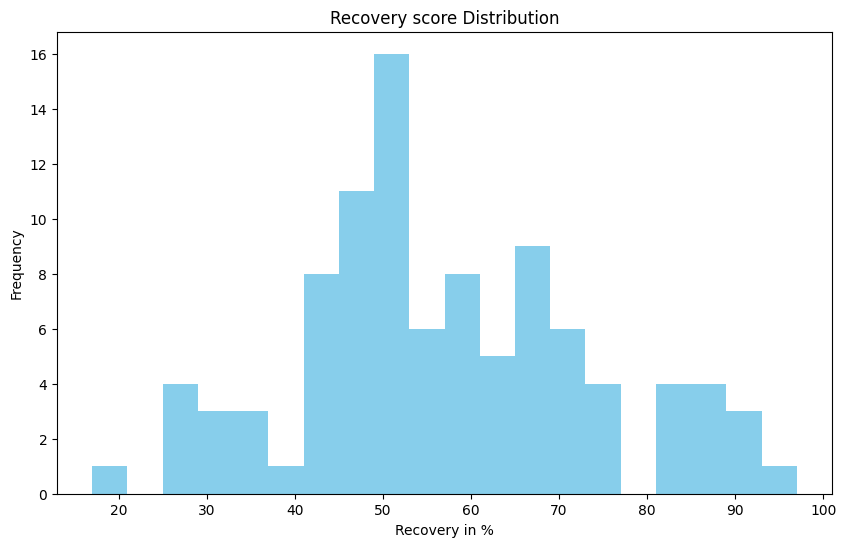

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(recovery_merged["Recovery_score"].round(), bins=20, color='skyblue')
plt.title('Recovery score Distribution')
plt.xlabel('Recovery in %')
plt.ylabel('Frequency')
plt.show()